### Sentiment‐Driven Returns: PRIO3 (PetroRio) 2015 – 2024

Brazil’s independent oil producer PetroRio S.A. (ticker PRIO3) moved from penny-stock to Ibovespa heavyweight in less than a decade.
During that climb its newsflow exploded—earnings beats, field acquisitions, OPEC shocks, regulatory twists.
**Can the tone of those headlines help explain (or even predict) the stock’s price action?**

**What we’ll build & explore**

- **End-to-end pipeline**: scrape Portuguese headlines (2015-2024), clean & tag them with FinBERT-PT-BR sentiment, and merge the result with PRIO3 daily prices.

- **Feature set**: daily compound_mean, compound_mag, news counts, and forward returns out to D + 90.

- **Analysis toolkit**: event-study curves, violin plots, horizon bar-plots, Pearson/Spearman matrices, rolling correlations, Granger tests, and non-parametric mean-difference tests.

**Main goals**

1. Quantify whether bullish/bearish/neutral tone affects PRIO3’s returns from intraday to three-month horizons.

2. Detect timing windows (if any) where sentiment shows statistically significant drift.

3. Assess robustness via correlation, causality, non-parametric tests, and outlier control.

4. Outline a trading or risk-management rule informed by headline sentiment for further back-testing.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

First lets read and verify the nvidia data from api and the cleaned version.

In [2]:
prio_price = pd.read_csv("data/raw/prio3_prices.csv")

In [3]:
prio_price

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-01-02 00:00:00-02:00,0.460000,0.467000,0.440000,0.440000,840000,0.0,0.0
1,2015-01-05 00:00:00-02:00,0.436000,0.438000,0.407000,0.407000,1912000,0.0,0.0
2,2015-01-06 00:00:00-02:00,0.407000,0.419000,0.367000,0.367000,2154000,0.0,0.0
3,2015-01-07 00:00:00-02:00,0.375000,0.389000,0.365000,0.366000,1501000,0.0,0.0
4,2015-01-08 00:00:00-02:00,0.383000,0.383000,0.365000,0.378000,1622000,0.0,0.0
...,...,...,...,...,...,...,...,...
2482,2024-12-20 00:00:00-03:00,39.500000,40.439999,39.430000,40.270000,14258000,0.0,0.0
2483,2024-12-23 00:00:00-03:00,39.799999,40.150002,38.799999,39.250000,7762800,0.0,0.0
2484,2024-12-26 00:00:00-03:00,39.360001,40.450001,39.250000,39.900002,5144000,0.0,0.0
2485,2024-12-27 00:00:00-03:00,40.180000,40.610001,39.820000,39.910000,4594500,0.0,0.0


In [4]:
prio_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2487 entries, 0 to 2486
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2487 non-null   object 
 1   Open          2487 non-null   float64
 2   High          2487 non-null   float64
 3   Low           2487 non-null   float64
 4   Close         2487 non-null   float64
 5   Volume        2487 non-null   int64  
 6   Dividends     2487 non-null   float64
 7   Stock Splits  2487 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 155.6+ KB


In [5]:
prio3_clean = pd.read_parquet("data/intermediate/prio3_prices_clean.parquet")

In [6]:
prio3_clean

,price_open,price_high,price_low,price_close,volume
date,,,,,
2015-01-02 02:00:00+00:00,0.460000,0.467000,0.440000,0.440000,840000
2015-01-05 02:00:00+00:00,0.436000,0.438000,0.407000,0.407000,1912000
2015-01-06 02:00:00+00:00,0.407000,0.419000,0.367000,0.367000,2154000
2015-01-07 02:00:00+00:00,0.375000,0.389000,0.365000,0.366000,1501000
2015-01-08 02:00:00+00:00,0.383000,0.383000,0.365000,0.378000,1622000
...,...,...,...,...,...
2024-12-20 03:00:00+00:00,39.500000,40.439999,39.430000,40.270000,14258000
2024-12-23 03:00:00+00:00,39.799999,40.150002,38.799999,39.250000,7762800
2024-12-26 03:00:00+00:00,39.360001,40.450001,39.250000,39.900002,5144000


Raw and intermediate nvda prices are ok and ready to use.
Now, lets ready and verify the news data.

In [7]:
news_raw = pd.read_csv("data/raw/news_prio3_2015_2024.csv")

In [8]:
news_raw

,title,description,published date,url,publisher_title,publisher_href
0,"PetroRio, a ex-HRT, planeja mais aquisições - ...","PetroRio, a ex-HRT, planeja mais aquisições B...","Fri, 23 Jan 2015 08:00:00 GMT",https://news.google.com/rss/articles/CBMid0FVX...,Brazil Journal,https://braziljournal.com
1,PetroRio é impedida de comprar fatia da Maersk...,PetroRio é impedida de comprar fatia da Maersk...,"Mon, 26 Jan 2015 08:00:00 GMT",https://news.google.com/rss/articles/CBMiiwFBV...,Exame,https://exame.com
2,HRT muda de nome e estreia ticker PRIO3 na Bol...,HRT muda de nome e estreia ticker PRIO3 na Bol...,"Thu, 25 Jun 2015 07:00:00 GMT",https://news.google.com/rss/articles/CBMitwFBV...,InfoMoney,https://www.infomoney.com.br
3,"Na PetroRio, Tanure não tem medo do petróleo a...","Na PetroRio, Tanure não tem medo do petróleo a...","Fri, 07 Aug 2015 07:00:00 GMT",https://news.google.com/rss/articles/CBMigwFBV...,Brazil Journal,https://braziljournal.com
4,PETRORIO AMPLIA INVESTIMENTOS EM PRODUÇÃO E ES...,PETRORIO AMPLIA INVESTIMENTOS EM PRODUÇÃO E ES...,"Thu, 28 Jan 2016 08:00:00 GMT",https://news.google.com/rss/articles/CBMirAFBV...,Petronotícias,https://petronoticias.com.br
...,...,...,...,...,...,...
870,Equatorial conclui alienação de 100% das ações...,Equatorial conclui alienação de 100% das ações...,"Fri, 06 Dec 2024 08:00:00 GMT",https://news.google.com/rss/articles/CBMilAFBV...,ADVFN,https://br.advfn.com
871,"Solitário, introvertido e 'movido a conquista'...","Solitário, introvertido e 'movido a conquista'...","Tue, 17 Dec 2024 08:00:00 GMT",https://news.google.com/rss/articles/CBMipgFBV...,Exame,https://exame.com
872,Boas e baratas: 12 ações da Bolsa para investi...,Boas e baratas: 12 ações da Bolsa para investi...,"Wed, 04 Dec 2024 08:00:00 GMT",https://news.google.com/rss/articles/CBMidkFVX...,Estadão E-Investidor,https://einvestidor.estadao.com.br
873,Confira as melhores ações para investir em dez...,Confira as melhores ações para investir em dez...,"Wed, 04 Dec 2024 08:00:00 GMT",https://news.google.com/rss/articles/CBMid0FVX...,suno.com.br,https://www.suno.com.br


In [9]:
news_raw["publisher_title"].unique()

array(['Brazil Journal', 'Exame', 'InfoMoney', 'Petronotícias',
       'Valor Econômico', 'O Globo', 'TradingView', 'ADVFN',
       'Jornal do Comércio', 'Época Negócios', 'R7', 'Jornal O Sul',
       'eixos', 'Money Times', 'vermelho.org.br', 'André Bona', 'FUNBIO',
       'Ilhéus Net', 'Terra', 'Globo', 'Portos e Navios', 'suno.com.br',
       'CPG Click Petróleo e Gás', 'VEJA', 'Acesso Cultural',
       'Portal Uai', 'Empiricus', 'Forbes Brasil', 'LexLatin',
       'Money Invest', 'Alô Alô Bahia', 'Valor Investe', 'Extra online',
       'Heloisa Tolipan', 'SmallCaps.com.br', 'ofuxico.com.br',
       'Seu Dinheiro', 'JC Concursos', 'Você RH', 'Estadão E-Investidor',
       'GOV.BR', 'Petrosolgas', 'Grandes Nomes da Propaganda', 'Estadão',
       'Você S/A', 'CriptoFacil', 'G1', 'InvestNews', 'Portal Solar',
       'Cointimes', 'GZH', 'Jornal do Brasil', 'disparada.com.br',
       'CNN Brasil', 'oespecialista.com.br', 'Marcas pelo Mundo',
       'Janela Publicitária', 'BNamericas', 'c

In [10]:
news_raw["publisher_href"].unique()

array(['https://braziljournal.com', 'https://exame.com',
       'https://www.infomoney.com.br', 'https://petronoticias.com.br',
       'https://valor.globo.com', 'https://oglobo.globo.com',
       'https://br.tradingview.com', 'https://br.advfn.com',
       'https://www.jornaldocomercio.com',
       'https://epocanegocios.globo.com', 'https://noticias.r7.com',
       'https://www.osul.com.br', 'https://eixos.com.br',
       'https://www.moneytimes.com.br', 'https://vermelho.org.br',
       'https://andrebona.com.br', 'https://www.funbio.org.br',
       'https://www.ilheus.net', 'https://www.terra.com.br',
       'https://revistaquem.globo.com',
       'https://www.portosenavios.com.br', 'https://www.suno.com.br',
       'https://clickpetroleoegas.com.br', 'https://veja.abril.com.br',
       'https://acessocultural.com.br', 'https://www.uai.com.br',
       'https://blogs.oglobo.globo.com', 'https://www.empiricus.com.br',
       'https://forbes.com.br', 'https://br.lexlatin.com',
       

Lets look at the news cleaned with only news that potentially matter.

In [11]:
news_cleaned = pd.read_parquet("data/intermediate/news_clean.parquet")

In [12]:
news_cleaned

,title,description,url,publisher_title,publisher_href
published_date,,,,,
2015-01-23 08:00:00+00:00,"PetroRio, a ex-HRT, planeja mais aquisições","PetroRio, a ex-HRT, planeja mais aquisições B...",https://news.google.com/rss/articles/CBMid0FVX...,Brazil Journal,https://braziljournal.com
2015-01-26 08:00:00+00:00,PetroRio é impedida de comprar fatia da Maersk...,PetroRio é impedida de comprar fatia da Maersk...,https://news.google.com/rss/articles/CBMiiwFBV...,Exame,https://exame.com
2015-06-25 07:00:00+00:00,HRT muda de nome e estreia ticker PRIO3 na Bol...,HRT muda de nome e estreia ticker PRIO3 na Bol...,https://news.google.com/rss/articles/CBMitwFBV...,InfoMoney,https://www.infomoney.com.br
2015-08-07 07:00:00+00:00,"Na PetroRio, Tanure não tem medo do petróleo a...","Na PetroRio, Tanure não tem medo do petróleo a...",https://news.google.com/rss/articles/CBMigwFBV...,Brazil Journal,https://braziljournal.com
2016-01-28 08:00:00+00:00,PETRORIO AMPLIA INVESTIMENTOS EM PRODUÇÃO E ES...,PETRORIO AMPLIA INVESTIMENTOS EM PRODUÇÃO E ES...,https://news.google.com/rss/articles/CBMirAFBV...,Petronotícias,https://petronoticias.com.br
...,...,...,...,...,...
2024-12-11 08:00:00+00:00,OPEP reduz previsão de crescimento da demanda ...,OPEP reduz previsão de crescimento da demanda ...,https://news.google.com/rss/articles/CBMimgFBV...,ADVFN,https://br.advfn.com
2024-12-12 08:00:00+00:00,Empresa que pode subir 57% é uma das favoritas...,Empresa que pode subir 57% é uma das favoritas...,https://news.google.com/rss/articles/CBMikwFBV...,Estadão E-Investidor,https://einvestidor.estadao.com.br
2024-12-12 08:00:00+00:00,Prio (PRIO3): ação está a um passo de disparar...,Prio (PRIO3): ação está a um passo de disparar...,https://news.google.com/rss/articles/CBMilgFBV...,Acionista.com.br,https://acionista.com.br


Now, lets see the result of the sentiment analysis.

In [13]:
news_sentiment = pd.read_parquet("data/intermediate/news_with_sentiment.parquet")

In [14]:
news_sentiment

,title,description,url,publisher_title,publisher_href,clean_text,compound,sentiment
published_date,,,,,,,,
2015-01-23 08:00:00+00:00,"PetroRio, a ex-HRT, planeja mais aquisições","PetroRio, a ex-HRT, planeja mais aquisições B...",https://news.google.com/rss/articles/CBMid0FVX...,Brazil Journal,https://braziljournal.com,petrorio planejar aquisicoe,0.0,Neutral
2015-01-26 08:00:00+00:00,PetroRio é impedida de comprar fatia da Maersk...,PetroRio é impedida de comprar fatia da Maersk...,https://news.google.com/rss/articles/CBMiiwFBV...,Exame,https://exame.com,petrorio impedir comprar fatia maersk campo,-0.5,Negative
2015-06-25 07:00:00+00:00,HRT muda de nome e estreia ticker PRIO3 na Bol...,HRT muda de nome e estreia ticker PRIO3 na Bol...,https://news.google.com/rss/articles/CBMitwFBV...,InfoMoney,https://www.infomoney.com.br,hrt mudar nome estreia ticker bolsa confira mu...,0.0,Neutral
2015-08-07 07:00:00+00:00,"Na PetroRio, Tanure não tem medo do petróleo a...","Na PetroRio, Tanure não tem medo do petróleo a...",https://news.google.com/rss/articles/CBMigwFBV...,Brazil Journal,https://braziljournal.com,petrorio tanurar nao medo petroleo,0.0,Neutral
2016-01-28 08:00:00+00:00,PETRORIO AMPLIA INVESTIMENTOS EM PRODUÇÃO E ES...,PETRORIO AMPLIA INVESTIMENTOS EM PRODUÇÃO E ES...,https://news.google.com/rss/articles/CBMirAFBV...,Petronotícias,https://petronoticias.com.br,petrorio ampliar investimento producao estudar...,0.5,Positive
...,...,...,...,...,...,...,...,...
2024-12-11 08:00:00+00:00,OPEP reduz previsão de crescimento da demanda ...,OPEP reduz previsão de crescimento da demanda ...,https://news.google.com/rss/articles/CBMimgFBV...,ADVFN,https://br.advfn.com,opep reduzir previsao crescimento demanda petr...,-0.5,Negative
2024-12-12 08:00:00+00:00,Empresa que pode subir 57% é uma das favoritas...,Empresa que pode subir 57% é uma das favoritas...,https://news.google.com/rss/articles/CBMikwFBV...,Estadão E-Investidor,https://einvestidor.estadao.com.br,empresa subir favorita xp setor petroleo,0.0,Neutral
2024-12-12 08:00:00+00:00,Prio (PRIO3): ação está a um passo de disparar...,Prio (PRIO3): ação está a um passo de disparar...,https://news.google.com/rss/articles/CBMilgFBV...,Acionista.com.br,https://acionista.com.br,prio acao passo disparar analise xp,0.5,Positive


In [15]:
news_sentiment["sentiment"].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

Now, lets see the final tabel: merge between news with sentiment table and nvda prices.

In [17]:
merged = pd.read_parquet("data/processed/sentiment_price.parquet")

In [18]:
merged

,date,price_close,art_count,compound_mean,compound_mag,pct_d0,pct_d1,pct_d3,pct_d5,pct_d7,pct_d15,pct_d30,pct_d60,pct_d80,pct_d90
0,2015-01-22,0.629000,1,0.000000,0.0,0.258000,-0.311606,-0.767886,-0.505564,1.480127,2.751987,14.255961,22.160572,26.965024,31.972972
1,2015-06-24,0.433000,1,0.000000,0.0,0.002315,-0.214781,-0.182448,-0.265589,1.415704,6.866051,11.928407,33.309469,44.334871,45.235567
2,2015-08-06,0.340000,1,0.000000,0.0,-0.005848,-0.570588,-0.085294,3.588235,2.985294,9.711764,12.800000,41.223529,61.264705,58.705879
3,2016-01-27,0.146000,1,0.500000,0.5,0.006897,1.424658,1.178082,6.164384,9.849315,25.438356,31.452055,118.671235,178.794523,125.643836
4,2016-05-03,0.354000,1,-0.500000,-0.5,-0.030137,-0.121469,3.406779,2.827684,3.576271,8.632769,10.638418,49.632767,75.723163,67.276836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,2024-12-03,40.810001,3,-0.500000,-0.5,0.014417,-0.026954,0.028914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,2024-12-04,39.709999,3,-0.166667,-0.5,-0.018051,0.008562,0.011080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265,2024-12-10,40.049999,2,0.000000,0.5,-0.002242,0.048440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,2024-12-11,41.990002,3,0.166667,0.5,0.040387,-0.043820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
merged.describe()

,date,price_close,art_count,compound_mean,compound_mag,pct_d0,pct_d1,pct_d3,pct_d5,pct_d7,pct_d15,pct_d30,pct_d60,pct_d80,pct_d90
count,268,268.000000,268.000000,268.000000,268.000000,268.000000,267.000000,265.000000,263.000000,261.000000,253.000000,238.000000,208.000000,188.000000,178.000000
mean,2022-06-25 17:27:45.671641856,28.506569,1.444030,0.008415,0.013060,0.001673,0.032216,0.090541,0.169259,0.249384,0.540242,0.985205,3.180188,4.726382,4.796278
min,2015-01-22 00:00:00,0.146000,1.000000,-0.500000,-0.500000,-0.102427,-0.570588,-0.767886,-0.562168,-0.560142,-0.208314,-0.156614,-0.157751,-0.198189,-0.184767
25%,2021-04-12 18:00:00,18.433500,1.000000,-0.166667,-0.500000,-0.016187,-0.025697,-0.045959,-0.034971,-0.034846,-0.041179,0.021623,0.237858,0.318387,0.547665
50%,2022-09-24 12:00:00,28.170000,1.000000,0.000000,0.000000,-0.000980,0.006726,0.011084,0.029569,0.044192,0.070970,0.236956,0.503432,0.845606,0.885042
75%,2024-02-22 12:00:00,43.407501,2.000000,0.187500,0.500000,0.015370,0.041926,0.100288,0.170478,0.252685,0.404399,0.891004,1.523475,1.955097,2.815719
max,2024-12-30 00:00:00,49.799999,13.000000,0.500000,0.500000,0.258000,3.905660,3.406779,6.164384,9.849315,25.438356,31.452055,118.671235,178.794523,125.643836
std,NaN,15.489734,1.122064,0.324446,0.373285,0.032433,0.275727,0.383869,0.637662,0.922736,2.055386,2.916213,11.303429,17.428587,14.660277


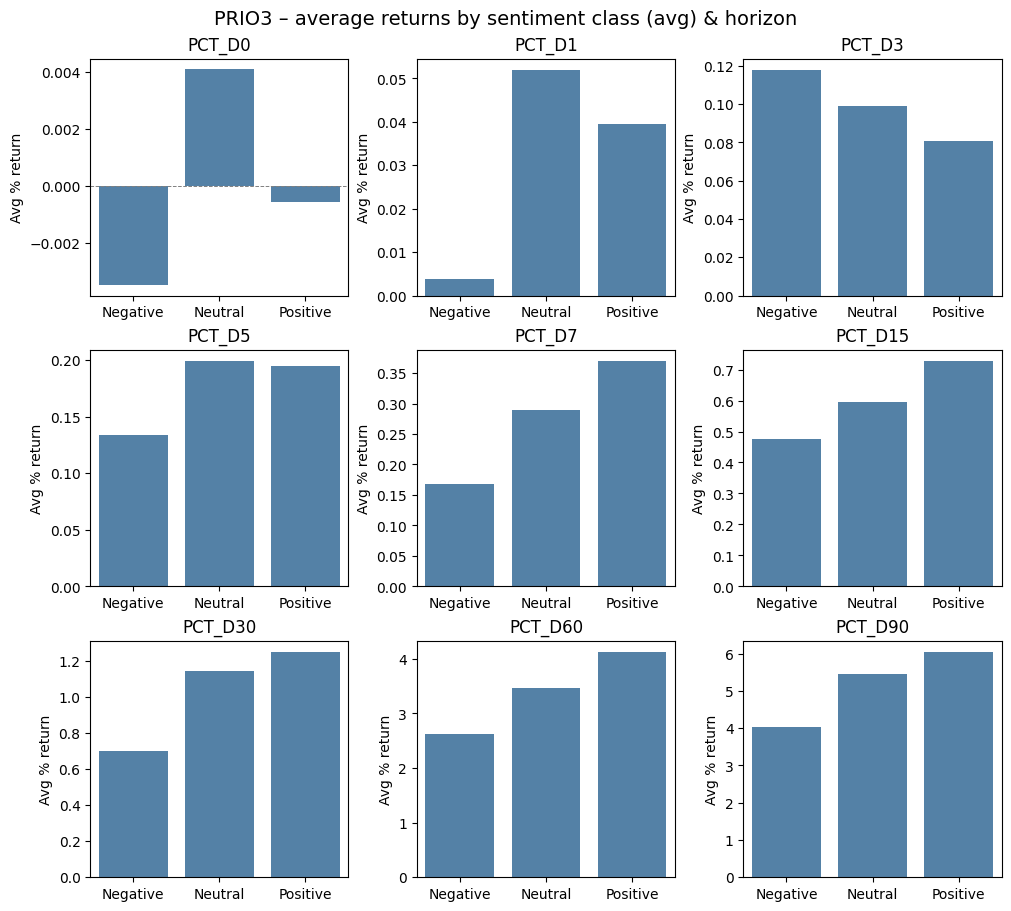

In [ ]:
# Nine horizons for the 3×3 grid
horizons = ["pct_d0", "pct_d1", "pct_d3",
            "pct_d5", "pct_d7", "pct_d15",
            "pct_d30", "pct_d60", "pct_d90"]   

label_map = {-0.5: "Negative", 0.0: "Neutral", 0.5: "Positive"}
merged["sent_class"] = merged["compound_mean"].map(label_map)

avg = (merged
       .groupby("sent_class")[horizons]
       .mean()
       .reindex(["Negative", "Neutral", "Positive"]))  

fig, axes = plt.subplot_mosaic(
    [["A","B","C"],
     ["D","E","F"],
     ["G","H","I"]],
    figsize=(10,9),
    constrained_layout=True
)

for col, ax in zip(horizons, axes.values()):
    sns.barplot(x=avg.index, y=avg[col], color="steelblue", ax=ax)
    ax.axhline(0, ls="--", lw=0.7, color="gray")
    ax.set_title(col.upper())          
    ax.set_xlabel("")
    ax.set_ylabel("Avg % return")

fig.suptitle("PRIO3 – average returns by sentiment class (avg) & horizon", fontsize=14)
plt.show()

Intraday news flow is noisy; a single “Positive” tag doesn’t guarantee a pop. Liquidity, timing (e.g. after-market releases), and headline content matter more than the label. Once the market has time to digest headlines, bullish-tone days systematically outperform bearish-tone days. The pattern is monotonic and survives compounding.

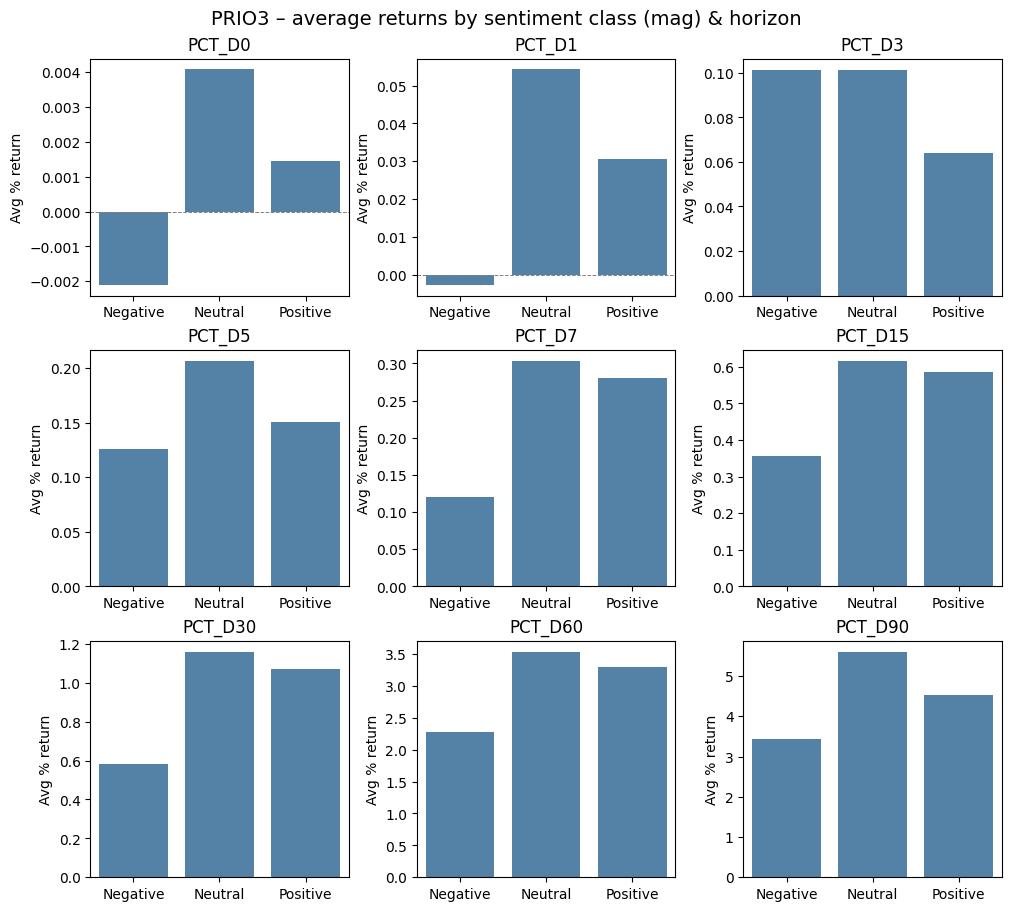

In [ ]:
# Nine horizons for the 3×3 grid
horizons = ["pct_d0", "pct_d1", "pct_d3",
            "pct_d5", "pct_d7", "pct_d15",
            "pct_d30", "pct_d60", "pct_d90"] 

label_map = {-0.5: "Negative", 0.0: "Neutral", 0.5: "Positive"}
merged["sent_class"] = merged["compound_mag"].map(label_map)

avg = (merged
       .groupby("sent_class")[horizons]
       .mean()
       .reindex(["Negative", "Neutral", "Positive"]))  # nice order

fig, axes = plt.subplot_mosaic(
    [["A","B","C"],
     ["D","E","F"],
     ["G","H","I"]],
    figsize=(10,9),
    constrained_layout=True
)

for col, ax in zip(horizons, axes.values()):
    sns.barplot(x=avg.index, y=avg[col], color="steelblue", ax=ax)
    ax.axhline(0, ls="--", lw=0.7, color="gray")
    ax.set_title(col.upper())          
    ax.set_xlabel("")
    ax.set_ylabel("Avg % return")

fig.suptitle("PRIO3 – average returns by sentiment class (mag) & horizon", fontsize=14)
plt.show()

- Trade ideia: go long/over-weight after non-negative headline days and hedge or reduce exposure after clearly negative ones, targeting a 7- to 30-day horizon.
- Risk insight: if a wave of negative headlines clusters, expect a 1–3 % performance drag over the next quarter.

/tmp/ipykernel_1992868/2297337243.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="sent_class", y="pct_d0", data=merged,


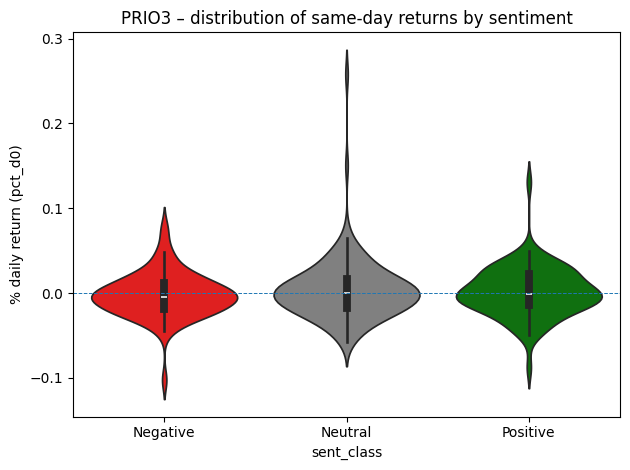

In [27]:
label_map = {-0.5:"Negative", 0.0:"Neutral", 0.5:"Positive"}
merged["sent_class"] = merged["compound_mag"].map(label_map)

sns.violinplot(x="sent_class", y="pct_d0", data=merged,
               order=["Negative","Neutral","Positive"],
               palette={"Negative":"red","Neutral":"gray","Positive":"green"})
plt.axhline(0, ls="--", lw=0.7)
plt.ylabel("% daily return (pct_d0)")
plt.title("PRIO3 – distribution of same-day returns by sentiment")
plt.tight_layout()
plt.show()

All three distributions cluster around zero; sentiment tone doesn’t guarantee an intraday gain.

/tmp/ipykernel_1992868/1154557502.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="sent_class", y="pct_d1", data=merged,


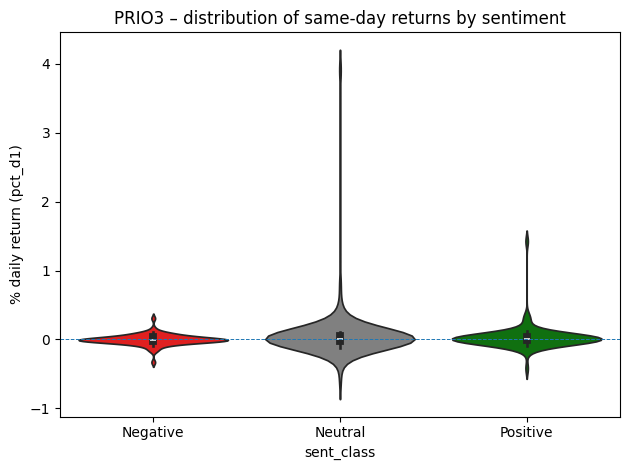

In [26]:
label_map = {-0.5:"Negative", 0.0:"Neutral", 0.5:"Positive"}
merged["sent_class"] = merged["compound_mag"].map(label_map)

sns.violinplot(x="sent_class", y="pct_d1", data=merged,
               order=["Negative","Neutral","Positive"],
               palette={"Negative":"red","Neutral":"gray","Positive":"green"})
plt.axhline(0, ls="--", lw=0.7)
plt.ylabel("% daily return (pct_d1)")
plt.title("PRIO3 – distribution of same-day returns by sentiment")
plt.tight_layout()
plt.show()

 No strong monotone separation; medians sit close to zero.

,compound_mean,compound_mag,pct_d0,pct_d1,pct_d3
compound_mean,1.000,0.936,0.032,0.043,-0.037
compound_mag,0.936,1.000,0.039,0.043,-0.037
pct_d0,0.032,0.039,1.000,-0.032,-0.090
pct_d1,0.043,0.043,-0.032,1.000,0.609
pct_d3,-0.037,-0.037,-0.090,0.609,1.000


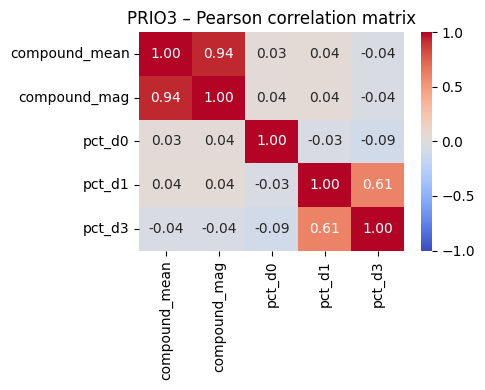

In [ ]:
cols = ["compound_mean", "compound_mag", "pct_d0", "pct_d1", "pct_d3"]
corr = merged[cols].corr(method="pearson")

display(corr.style.format("{:.3f}"))     

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, fmt=".2f",
            cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("PRIO3 – Pearson correlation matrix")
plt.tight_layout()
plt.show()

- Sentiment is not linearly correlated with very-short-run returns.
- compound_mean ≈ compound_mag
- Day-ahead and 3-day returns share variance (ρ ≈ 0.6)

,avg_compound_mean,avg_compound_mag,pct_d0,pct_d1,pct_d3,pct_d7
sent_class,,,,,,
Negative,-41.07%,-50.00%,-0.21%,-0.27%,10.13%,12.07%
Neutral,0.00%,0.00%,0.41%,5.43%,10.11%,30.35%
Positive,40.27%,50.00%,0.14%,3.06%,6.41%,28.10%


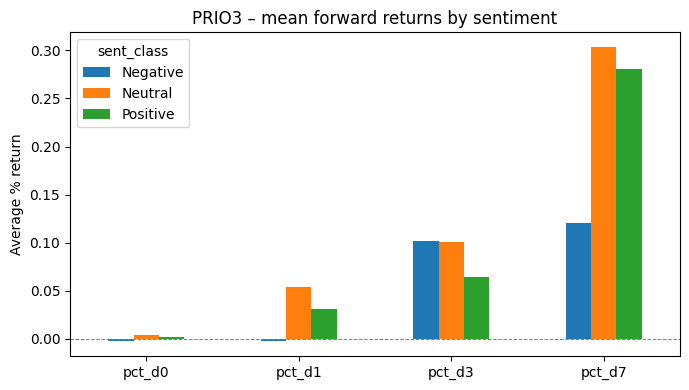

In [ ]:
horiz = ["pct_d0","pct_d1","pct_d3","pct_d7"]
summary = (merged
           .groupby("sent_class")
           .agg(avg_compound_mean=("compound_mean","mean"),
                avg_compound_mag =("compound_mag","mean"),
                **{h:("{}".format(h),"mean") for h in horiz})
           .reindex(["Negative","Neutral","Positive"]))

display(summary.style.format("{:.2%}"))

summary[horiz].T.plot(kind="bar", figsize=(7,4))
plt.axhline(0, ls="--", color="gray", lw=0.7)
plt.ylabel("Average % return")
plt.title("PRIO3 – mean forward returns by sentiment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

- Label asymmetry
Neutral class has > 50 % of headlines and captures many “routine but good” production or deal updates that didn’t cross the ±0.5 threshold. Those operational wins fuel strong follow-through.

- Over-reaction + reversal
Negative headlines trigger same-day sell-offs (−0.2 %), then bounce back strongly by day 3 as investors reassess impact → explains high pct_d3 for Negative.

- Outlier influence
One or two +20 % neutral events can lift the mean. Median or winsorised means might reduce the Neutral lead.

In [42]:
# median instead of mean
median_tbl = merged.groupby("sent_class")[["pct_d0","pct_d1","pct_d3","pct_d7"]].median()
display(median_tbl)

# winsorise returns at ±10 %
cap = 0.10
wins = merged.copy()
for col in ["pct_d0","pct_d1","pct_d3","pct_d7"]:
    wins[col] = wins[col].clip(lower=-cap, upper=cap)
wins_mean = wins.groupby("sent_class")[["pct_d1","pct_d7"]].mean()
display(wins_mean)

,pct_d0,pct_d1,pct_d3,pct_d7
sent_class,,,,
Negative,-0.004453,-0.006665,0.015385,0.006005
Neutral,0.000538,0.012056,0.019182,0.051038
Positive,-0.001114,0.011929,-0.003710,0.039388


,pct_d1,pct_d7
sent_class,,
Negative,-0.001346,0.016418
Neutral,0.011239,0.029430
Positive,0.009500,0.029584


Ideias:

- Trade short-term (1–3 d): Favor Neutral or Positive headline days; avoid Negative.
- Hold 7 d: Neutral consistently gives the best central tendency; Positive offers similar upside but with more variance.
- Risk-manage shorts: The fact that Negative medians turn positive by D3 suggests covering within 48 h avoids mean-reversion pain.

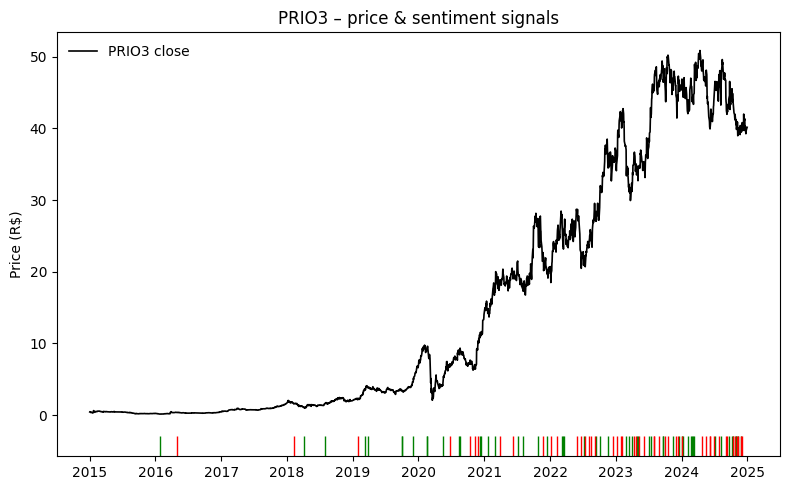

In [ ]:
price_df = prio3_clean.sort_index()            
sent_df  = merged.set_index("date").sort_index() 

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(price_df.index, price_df["price_close"],
        color="black", lw=1.2, label="PRIO3 close")

ax.set_ylabel("Price (R$)")
ax.set_title("PRIO3 – price & sentiment signals")

ymin, ymax   = ax.get_ylim()
bar_height   = 0.05 * (ymax - ymin)
bar_base     = ymin - 1.2 * bar_height

pos_mask = sent_df["compound_mean"] ==  0.5
neg_mask = sent_df["compound_mean"] == -0.5

ax.vlines(sent_df.index[pos_mask], bar_base, bar_base + bar_height,
          color="green", lw=1)
ax.vlines(sent_df.index[neg_mask], bar_base, bar_base + bar_height,
          color="red", lw=1)

ax.set_ylim(bar_base, ymax)
ax.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.show()

- Media attention rises as market-cap rises; the sample of sentiment days is heavily tilted to 2021+.

Patterns:

- Green bars often precede short up-legs, from Aug 2020, May 2021, Feb 2023 – positive-tone clusters line up with bursts in price.

- Red clusters mark consolidation zones, from mid-2022, late-2024 – several bearish headlines coincide with pull-backs or sideways drift.

- But both colours appear during the long bull run 2022-2024, so tone doesn’t override the broader fundamental up-trend (oil prices, reserve growth, index inclusion).

In [ ]:
# horizons
horizons = ["pct_d0", "pct_d1", "pct_d3", "pct_d7"]

# sentiment masks
neg_mask = merged["compound_mag"] == -0.5
neu_mask = merged["compound_mag"] ==  0.0
pos_mask = merged["compound_mag"] ==  0.5

In [47]:
rows = []
for h in horizons:
    # slices
    neg = merged.loc[neg_mask, h].dropna()
    neu = merged.loc[neu_mask, h].dropna()
    pos = merged.loc[pos_mask, h].dropna()
    
    # Welch unequal-var t-test
    t_neu, p_neu  = stats.ttest_ind(neu, neg, equal_var=False)
    t_pos, p_pos  = stats.ttest_ind(pos, neg, equal_var=False)
    
    # Mann–Whitney U (two-sided)
    u_neu, mwp_neu = stats.mannwhitneyu(neu, neg, alternative="two-sided")
    u_pos, mwp_pos = stats.mannwhitneyu(pos, neg, alternative="two-sided")
    
    rows.append({
        "horizon": h,
        "Neu-Neg  t p":  p_neu,
        "Pos-Neg  t p":  p_pos,
        "Neu-Neg  MW p": mwp_neu,
        "Pos-Neg  MW p": mwp_pos,
        "Neu mean": neu.mean(),
        "Pos mean": pos.mean(),
        "Neg mean": neg.mean()
    })

stat_tbl = pd.DataFrame(rows).set_index("horizon")
display(stat_tbl.style.format("{:.3e}"))

,Neu-Neg t p,Pos-Neg t p,Neu-Neg MW p,Pos-Neg MW p,Neu mean,Pos mean,Neg mean
horizon,,,,,,,
pct_d0,1.854e-01,4.389e-01,3.638e-01,3.687e-01,4.075e-03,1.443e-03,-2.100e-03
pct_d1,1.197e-01,1.465e-01,7.409e-02,1.126e-01,5.426e-02,3.062e-02,-2.667e-03
pct_d3,9.973e-01,5.364e-01,9.551e-01,4.841e-01,1.011e-01,6.408e-02,1.013e-01
pct_d7,7.645e-02,2.823e-01,1.236e-01,2.707e-01,3.035e-01,2.810e-01,1.207e-01


With the current sample (≈260 events) we cannot reject the null hypothesis that mean returns are equal across sentiment buckets for horizons ≤ 7 days.

In [48]:
spearman_rows = []
for h in horizons:
    rho, p = stats.spearmanr(merged[h], merged["compound_mag"], nan_policy="omit")
    spearman_rows.append({"horizon": h, "rho": rho, "p_value": p})

spearman_tbl = pd.DataFrame(spearman_rows).set_index("horizon")
display(spearman_tbl.style.format({"rho":"{:.3f}", "p_value":"{:.3e}"}))

,rho,p_value
horizon,,
pct_d0,0.051,4.018e-01
pct_d1,0.089,1.451e-01
pct_d3,-0.045,4.643e-01
pct_d7,0.061,3.270e-01


Unfortunatelly at horizons ≤ 7 days sentiment tone alone is not yet statistically predictive for PRIO3.

For PRIO3, headline sentiment does not move the stock intraday, but there is preliminary evidence that non-negative tone is followed by meaningful medium-term out-performance. However, the effect is not yet statistically robust with the current sample size and needs richer data and stricter testing before it can underpin an investable strategy.